# One-dimensional consolidation

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

This notebook was developed based on [this resource](https://yaredwb.github.io/FDM1D/) provided by [Dr. Y. Bekele](https://yaredwb.com/), and the book **An Introduction
to Soil Mechanics** by [A. Verruijt (2018)](https://doi.org/10.1007/978-3-319-61185-3).

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/consolidation_1D.ipynb).


## Governing equation

The partial differential equation governing one-dimensional consolidation is given by the following diffussion equation:

$$
\frac{\partial p_\mathrm{w}}{\partial t} = c_\mathrm{v} \frac{\partial^2 p_\mathrm{w}}{\partial z^2}
$$

where $p_\mathrm{w}$ is the excess pore water pressure, $t$ stands for time, $z$ represents depth and $c_\mathrm{v}$ is the coefficient of consolidation which can be expressed as

$$
c_\mathrm{v} = \frac{k}{m_\mathrm{v} \gamma_w}
$$

with
- $k$: coefficient of permeability, 
- $m_\mathrm{v}$: the coefficient of volumetric compressibility, and 
- $\gamma_w$: the unit weight of water.

## Required modules and global setup for plots

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'


## Functions

In [2]:
def numercial_sol(h, cv, t_add=None, t_max=72, Δt=100, N=30, doub_drainage=True, widget=False):
    # Mesh
    t_max *= 3600  # Convert time to seconds. Maximum time for the simulation
    Nt = int(t_max / Δt) + 1  # Number of time steps
    Δz = h / N  # Node spacing for a uniform discretization
    z = np.linspace(0, h, N + 1)
    if doub_drainage:
        H = h/2  # Drainage path length
    else:
        H = h
        N += 1 # Additional node at bottom for double drainage

    # Crack-Nicolson scheme
    Δσ = 1.  # Solution given as a fraction of Δσ
    𝜅 = cv * Δt / Δz**2
    A = sp.sparse.diags([-0.5*𝜅, 1+𝜅, -0.5*𝜅], [-1, 0, 1], shape=(N-1, N-1)).toarray()
    pw_prev = np.full(N + 1, Δσ)  # Initial condition → t = 0 : pw = Δσ
    pw = np.full(N + 1, Δσ)#np.copy(pw_prev)

    # Save the results for the desired times
    solutions, deg_cons, deg_cons_T = [], [], []

    T_obj = [2, 1, .5, .2, .1, .05, .02, .01, 0.001]
    if t_add is not None and t_add > 0:
        t_add = cv * t_add / H**2
        T_obj.append(t_add)
    T_obj.sort(reverse=True)

    # Compute the pore pressure for subsequent time steps
    for n in range(Nt):
        pw[0] = 0  # Boundary condition at the top
        pw[-1] = 0 if doub_drainage else pw[-2]  # Boundary condition at the bottom

        T = cv * n * Δt / H**2 # Dimensionless time
        if n == 1 and T > 0.001:
            Δt_t = 0.001 * H**2 / cv
            𝜅_t = cv * Δt_t / Δz**2
            b = 0.5 * 𝜅_t * pw_prev[:-2] + (1 - 𝜅_t) * pw_prev[1:-1] + 0.5 * 𝜅_t * pw_prev[2:]
            T = cv * n * Δt_t / H**2 # Dimensionless time
        else:
            b = 0.5 * 𝜅 * pw_prev[:-2] + (1 - 𝜅) * pw_prev[1:-1] + 0.5 * 𝜅 * pw_prev[2:]

        b[0] += 0.5 * 𝜅 * pw[0]
        b[-1] += 0.5 * 𝜅 * pw[-1]
        pw[1:-1] = np.linalg.solve(A, b)
        pw_prev = np.copy(pw) # Update the previous solution

        # Save results for plotting
        if (n % 50 == 0 or T >= T_obj[-1]) and T > 0:
            U = sp.integrate.trapezoid(y=(Δσ-pw_prev), dx=Δz)/h
            deg_cons.append(U)
            deg_cons_T.append(T)
        if T >= T_obj[-1]:
            solutions.append((T, pw_prev))
            T_obj.pop()
        if not T_obj:  # Stop when all the desired times are reached
            break

    # Plot results
    fig, axs = plt.subplots(ncols=1, nrows=2, layout='constrained', figsize=(4.5, 6))
    # Power pressure
    axs[0].set_prop_cycle(color=plt.colormaps['gnuplot'](np.linspace(0, 1, len(solutions))))
    for sol in solutions:
        pw2plot = sol[1] if doub_drainage else sol[1][:-1]
        axs[0].plot(pw2plot/Δσ, z/h, label=f'$T={sol[0]:.3f}$')
    axs[0].set(xlabel='$p_\mathrm{w} / \\Delta \\sigma$', ylabel='$z / h$',
           xlim=[-.1, 1.1])
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='$T=c_\\mathrm{v}\ t\ h^{-2}$')
    axs[0].xaxis.set_label_position("top")
    axs[0].xaxis.tick_top()
    axs[0].spines[["left", "top"]].set_linewidth(1.5)
    # Degree of consolidation
    axs[1].plot(deg_cons_T, deg_cons, 'k')
    axs[1].set(ylim=(-.1, 1.1), xlabel='$T=c_\\mathrm{v}\ t\ h^{-2}$',
               ylabel='Deg. of consolidation, $U$')
    axs[1].set_xscale('log')
    axs[1].spines[["left", "bottom"]].set_linewidth(1.5)
    for ax in axs:
        ax.invert_yaxis()
        ax.grid(True, which="both", color="gray", linestyle="--")
    if widget:
        display(fig)
    else:
        plt.show()
        display(wgt.HTML(html_setup))
    plt.close()
    return


## Example

### Input data

In [3]:
# Material inputs
h = 1.0  # Depth/thickness of the soil layer/sample  [m]
cv = 2e-6  # Coefficient of consolidation  [m²/s]

# Mesh inputs
N = 80  # Number of elements of 1D mesh (N+1 nodes)
t_add = None # A specific additional time for visualization [h]
t_max = 10 * 24  # Maximum time for visualization [h]
Δt = 100  # Time step  [s]


### Solution for single drainage

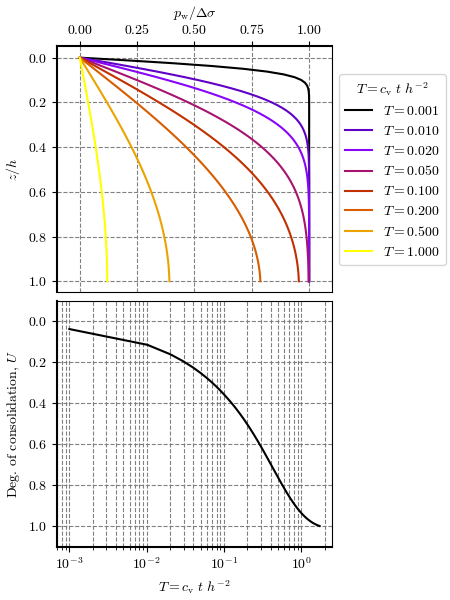

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [4]:
doub_drainage = False
numercial_sol(h, cv, t_add, t_max, Δt, N, doub_drainage)


### Solution for double drainage

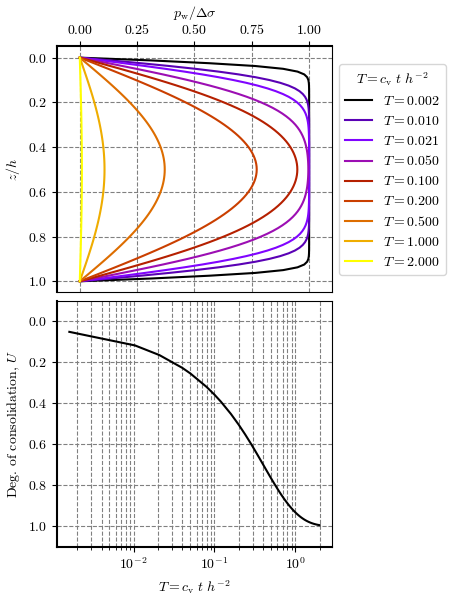

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [5]:
doub_drainage = True
numercial_sol(h, cv, t_add, t_max, Δt, N, doub_drainage)


In [6]:
s, l = {'description_width': '100px'}, wgt.Layout(width='450px')
controls = {
    'h': wgt.BoundedFloatText(value=1, min=0.001, max=10, step=0.1, description='h [m]', style=s, layout=l),
    'cv': wgt.BoundedFloatText(value=2e-6, min=1e-10, max=1, step=1e-6, description='Cv [m²/s]', style=s, layout=l),
    't_add': wgt.FloatText(value=None, min=0, max=100, step=1, description='Extra t [h]', style=s, layout=l),
    't_max': wgt.BoundedFloatText(value=72, min=0, max=500, step=1, description='Max. t [h]', style=s, layout=l),
    'Δt': wgt.BoundedFloatText(value=80, min=1, max=1000, step=1, description='Δt [s]', style=s, layout=l),
    'N': wgt.BoundedIntText(value=50, min=1, max=100, step=1, description='N', style=s, layout=l),
    'doub_drainage': wgt.Checkbox(value=True, description='Double drainage', disabled=False, style=s, layout=l),
    'widget': wgt.Checkbox(value=True, description='Non-vector image (improve widget performance)', disabled=False, style=s, layout=l)
}
fig = wgt.interactive_output(numercial_sol, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))
